In [2]:
# Cell 1.1: Cài đặt thư viện
!pip install torch torchvision numpy matplotlib opencv-python-headless pillow scikit-learn seaborn tqdm

In [1]:
# Cell 1.2: Import các thư viện
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import numpy as np
import cv2
import random
import os
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Bỏ qua các cảnh báo không cần thiết
warnings.filterwarnings('ignore')

In [3]:
# Cell 1.3: Cấu hình chung (Device, Seed, Paths)
# 1. Thiết lập device (Sử dụng GPU nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng device: {device}")

# 2. Thiết lập seed để kết quả nhất quán
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 3. Khai báo các đường dẫn chính
# (Hãy đảm bảo bạn đã mount Google Drive)
DRIVE_PATH = "/content/drive/MyDrive/XLA"
# Thư mục chứa data gốc (bạn tự vẽ) - NẾU CÓ
ORIG_DATA_PATH = os.path.join(DRIVE_PATH, "data")
# Thư mục chứa data tự sinh (MỚI)
GEN_DATA_PATH = "/content/data_gen"
# Thư mục chứa data đã augmentation (kết quả)
AUG_DATA_PATH = "/content/data_aug"

# Tạo các thư mục nếu chưa có
os.makedirs(DRIVE_PATH, exist_ok=True)
os.makedirs(GEN_DATA_PATH, exist_ok=True)
os.makedirs(AUG_DATA_PATH, exist_ok=True)

Đang sử dụng device: cuda


In [4]:
# Phần 2: Sinh Dữ liệu Hình học
# Cell 2.1: Định nghĩa hàm generate_shapes
def generate_shapes(output_dir, shape_type, num_images=1000, size=28):
    """
    Tự động sinh ảnh hình học cơ bản (nền đen, hình trắng).
    """
    os.makedirs(output_dir, exist_ok=True)

    for i in range(num_images):
        img = np.zeros((size, size), dtype=np.uint8)
        color = 255
        thickness = 1

        center_x = random.randint(10, 18)
        center_y = random.randint(10, 18)
        radius = random.randint(5, 10)

        if shape_type == "circle":
            cv2.circle(img, (center_x, center_y), radius, color, thickness)

        elif shape_type == "rectangle":
            x1 = max(center_x - radius, 0)
            y1 = max(center_y - radius, 0)
            x2 = min(center_x + radius, size-1)
            y2 = min(center_y + radius, size-1)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

        elif shape_type == "triangle":
            pts = np.array([
                [center_x, center_y - radius],
                [center_x - radius, center_y + radius],
                [center_x + radius, center_y + radius]
            ], np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(img, [pts], isClosed=True, color=color, thickness=thickness)

        save_path = os.path.join(output_dir, f"gen_{shape_type}_{i}.png")
        cv2.imwrite(save_path, img)

In [5]:
# Cell 2.2: Chạy hàm generate_shapes
print("Đang sinh dữ liệu hình học...")
generate_shapes(os.path.join(GEN_DATA_PATH, "circle"), "circle", 1000)
generate_shapes(os.path.join(GEN_DATA_PATH, "rectangle"), "rectangle", 1000)
generate_shapes(os.path.join(GEN_DATA_PATH, "triangle"), "triangle", 1000)
print(f"Đã sinh xong dữ liệu vào thư mục: {GEN_DATA_PATH}")

Đang sinh dữ liệu hình học...
Đã sinh xong dữ liệu vào thư mục: /content/data_gen


In [6]:
# Phần 3: Augmentation Dữ liệu
# Cell 3.1: Hàm mnist_style_resize
def mnist_style_resize(img, size=28, digit_size=20):
    """
    Hàm tiền xử lý resize và đưa về chuẩn MNIST (từ code cũ của bạn).
    """
    img = img.convert("L")
    bbox = img.getbbox()
    if bbox:
        img = img.crop(bbox)
    max_side = max(img.size)
    scale = digit_size / max_side
    new_size = tuple([int(x * scale) for x in img.size])
    img = img.resize(new_size, Image.LANCZOS)
    img = img.filter(ImageFilter.UnsharpMask(radius=1, percent=150, threshold=3))
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)
    new_img = Image.new("L", (size, size), 0)
    paste_x = (size - new_size[0]) // 2
    paste_y = (size - new_size[1]) // 2
    new_img.paste(img, (paste_x, paste_y))
    return new_img

In [7]:
# Cell 3.2: Hàm thicken_lines và random_augment_mnist_style
def thicken_lines(img, thickness=2):
    """
    Làm dày nét (dùng cv2.dilate).
    """
    np_img = np.array(img)
    if np_img.ndim == 3:
        np_img = np.img_to_array[:, :, 0]
    kernel = np.ones((thickness, thickness), np.uint8)
    dilated = cv2.dilate(np_img, kernel, iterations=1)
    return Image.fromarray(dilated)

def random_augment_mnist_style(img):
    """
    Augmentation ngẫu nhiên (xoay và làm dày).
    """
    if random.random() < 0.8:
        angle = random.uniform(-20, 20)
        img = img.rotate(angle, fillcolor=0)
    if random.random() < 0.7:
        img = thicken_lines(img, thickness=2)
    return img

In [8]:
# Cell 3.3: Hàm augment_with_custom_effects
def augment_with_custom_effects(input_dirs, output_dir, target_count=7000):
    """
    Nâng cấp: Lấy ảnh từ một DANH SÁCH các thư mục đầu vào
    (bao gồm data gốc của bạn và data mới sinh).
    """
    os.makedirs(output_dir, exist_ok=True)

    images = []
    for input_dir in input_dirs:
        if os.path.exists(input_dir):
            images.extend([
                os.path.join(input_dir, f)
                for f in os.listdir(input_dir)
                if f.lower().endswith(('.png', '.jpg'))
            ])
        else:
            print(f"Cảnh báo: Không tìm thấy thư mục {input_dir}")

    if not images:
        print(f"Lỗi: Không tìm thấy ảnh nào trong {input_dirs} để augment cho {output_dir}")
        return

    count = 0
    print(f"Bắt đầu augment cho {output_dir}...")
    pbar = tqdm(total=target_count)
    while count < target_count:
        img_path = random.choice(images)
        try:
            img = Image.open(img_path)
            img = mnist_style_resize(img)
            img = random_augment_mnist_style(img)
            save_path = os.path.join(output_dir, f"aug_{count}.png")
            img.save(save_path)
            count += 1
            pbar.update(1)
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_path}: {e}")

    pbar.close()
    print(f"✅ Hoàn thành augmenting {output_dir} với {target_count} ảnh")

In [9]:
# Cell 3.4: Chạy Augmentation (Gộp 2 nguồn data)
print("--- Bắt đầu chạy Augmentation cho 3 lớp hình học ---")

# Gộp data gốc (nếu có) + data mới sinh
circle_inputs = [os.path.join(ORIG_DATA_PATH, "circle"), os.path.join(GEN_DATA_PATH, "circle")]
rect_inputs = [os.path.join(ORIG_DATA_PATH, "rectangle"), os.path.join(GEN_DATA_PATH, "rectangle")]
tri_inputs = [os.path.join(ORIG_DATA_PATH, "triangle"), os.path.join(GEN_DATA_PATH, "triangle")]

augment_with_custom_effects(circle_inputs, os.path.join(AUG_DATA_PATH, "circle"), 7000)
augment_with_custom_effects(rect_inputs, os.path.join(AUG_DATA_PATH, "rectangle"), 7000)
augment_with_custom_effects(tri_inputs, os.path.join(AUG_DATA_PATH, "triangle"), 7000)

print("--- Đã augment xong ---")

--- Bắt đầu chạy Augmentation cho 3 lớp hình học ---
Cảnh báo: Không tìm thấy thư mục /content/drive/MyDrive/XLA/data/circle
Bắt đầu augment cho /content/data_aug/circle...


100%|██████████| 7000/7000 [00:03<00:00, 1789.48it/s]


✅ Hoàn thành augmenting /content/data_aug/circle với 7000 ảnh
Cảnh báo: Không tìm thấy thư mục /content/drive/MyDrive/XLA/data/rectangle
Bắt đầu augment cho /content/data_aug/rectangle...


100%|██████████| 7000/7000 [00:03<00:00, 1754.37it/s]


✅ Hoàn thành augmenting /content/data_aug/rectangle với 7000 ảnh
Cảnh báo: Không tìm thấy thư mục /content/drive/MyDrive/XLA/data/triangle
Bắt đầu augment cho /content/data_aug/triangle...


100%|██████████| 7000/7000 [00:03<00:00, 1757.82it/s]

✅ Hoàn thành augmenting /content/data_aug/triangle với 7000 ảnh
--- Đã augment xong ---


In [10]:
# Phần 4: Tải Dữ liệu & Dataset
# Cell 4.1: Định nghĩa Transforms
# Dùng mean/std của MNIST
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1))
    ], p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print("Đã định nghĩa Train và Test Transforms.")

Đã định nghĩa Train và Test Transforms.


In [11]:
# Cell 4.2: Định nghĩa các Lớp Dataset (ShapeDataset, ShapeOnlyDataset)
class ShapeDataset(Dataset):
    """Dataset cho các hình (nhãn 10, 11, 12)."""
    def __init__(self, root_dir, label, max_samples=None, transform=None):
        self.root_dir = root_dir
        self.files = sorted([
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ])
        if max_samples:
            self.files = self.files[:max_samples]
        self.label = label
        self.transform = transform
        self.targets = [label] * len(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, self.label

class ShapeOnlyDataset(ShapeDataset):
    """Dataset cho các hình (nhãn 0, 1, 2) cho model 3."""
    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return img, label - 10 # Ánh xạ lại nhãn: 10->0, 11->1, 12->2

print("Đã định nghĩa ShapeDataset và ShapeOnlyDataset.")

Đã định nghĩa ShapeDataset và ShapeOnlyDataset.


In [12]:
# Cell 4.3: Tải và chia MNIST (Cho Model 1 & 2)
print("Đang tải MNIST...")
mnist_train_full = torchvision.datasets.MNIST(
    root=DRIVE_PATH, train=True, download=True, transform=train_transform
)
mnist_test_full = torchvision.datasets.MNIST(
    root=DRIVE_PATH, train=False, download=True, transform=test_transform
)

# Chia MNIST test -> validation + test
val_size_mnist = int(0.5 * len(mnist_test_full))
test_size_mnist = len(mnist_test_full) - val_size_mnist
generator = torch.Generator().manual_seed(42)
mnist_val, mnist_test = random_split(mnist_test_full, [val_size_mnist, test_size_mnist], generator=generator)

# Dataset cho Model 2 (Digits Only)
dataset_digits_train = mnist_train_full
dataset_digits_val = mnist_val
dataset_digits_test = mnist_test

print(f"Digits - Train: {len(dataset_digits_train)}, Val: {len(dataset_digits_val)}, Test: {len(dataset_digits_test)}")

Đang tải MNIST...


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.26MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.49MB/s]

Digits - Train: 60000, Val: 5000, Test: 5000


In [13]:
# Cell 4.4: Tải và chia Hình học (Cho Model 1 & 3)
print("Đang tải dữ liệu hình học...")
base_dir = AUG_DATA_PATH
train_size = 6000
val_ratio = 0.5
generator = torch.Generator().manual_seed(42)

def load_and_split_shapes(DatasetClass, label_name, label, transform):
    """Hàm trợ giúp để tải và chia 1 lớp hình học."""
    full_dataset = DatasetClass(os.path.join(base_dir, label_name), label=label, max_samples=7000, transform=transform)
    train_set, test_temp_set = random_split(full_dataset, [train_size, len(full_dataset) - train_size], generator=generator)
    val_size = int(len(test_temp_set) * val_ratio)
    test_size = len(test_temp_set) - val_size
    val_set, test_set = random_split(test_temp_set, [val_size, test_size], generator=generator)

    val_set.dataset.transform = test_transform
    test_set.dataset.transform = test_transform
    print(f"Lớp {label_name} (Nhãn {label}) - Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    return train_set, val_set, test_set

# Data cho Model 1 (Nhãn 10, 11, 12)
print("--- Đang chia Data cho Model 1 (Nhãn 10, 11, 12) ---")
circle_train_m1, circle_val_m1, circle_test_m1 = load_and_split_shapes(ShapeDataset, "circle", 10, train_transform)
rect_train_m1, rect_val_m1, rect_test_m1 = load_and_split_shapes(ShapeDataset, "rectangle", 11, train_transform)
tri_train_m1, tri_val_m1, tri_test_m1 = load_and_split_shapes(ShapeDataset, "triangle", 12, train_transform)

# Data cho Model 3 (Nhãn 0, 1, 2)
print("--- Đang chia Data cho Model 3 (Nhãn 0, 1, 2) ---")
circle_train_m3, circle_val_m3, circle_test_m3 = load_and_split_shapes(ShapeOnlyDataset, "circle", 10, train_transform)
rect_train_m3, rect_val_m3, rect_test_m3 = load_and_split_shapes(ShapeOnlyDataset, "rectangle", 11, train_transform)
tri_train_m3, tri_val_m3, tri_test_m3 = load_and_split_shapes(ShapeOnlyDataset, "triangle", 12, train_transform)

Đang tải dữ liệu hình học...
--- Đang chia Data cho Model 1 (Nhãn 10, 11, 12) ---
Lớp circle (Nhãn 10) - Train: 6000, Val: 500, Test: 500
Lớp rectangle (Nhãn 11) - Train: 6000, Val: 500, Test: 500
Lớp triangle (Nhãn 12) - Train: 6000, Val: 500, Test: 500
--- Đang chia Data cho Model 3 (Nhãn 0, 1, 2) ---
Lớp circle (Nhãn 10) - Train: 6000, Val: 500, Test: 500
Lớp rectangle (Nhãn 11) - Train: 6000, Val: 500, Test: 500
Lớp triangle (Nhãn 12) - Train: 6000, Val: 500, Test: 500


In [14]:
# Cell 4.5: Gộp và tạo DataLoaders (Model 1 - All 13 Lớp)
# Model 1: All 13 Classes
dataset_all_train = ConcatDataset([mnist_train_full, circle_train_m1, rect_train_m1, tri_train_m1])
dataset_all_val = ConcatDataset([mnist_val, circle_val_m1, rect_val_m1, tri_val_m1])
dataset_all_test = ConcatDataset([mnist_test, circle_test_m1, rect_test_m1, tri_test_m1])
print(f"Model 1 (All) - Train: {len(dataset_all_train)}, Val: {len(dataset_all_val)}, Test: {len(dataset_all_test)}")

train_loader_all = DataLoader(dataset_all_train, batch_size=128, shuffle=True)
val_loader_all = DataLoader(dataset_all_val, batch_size=1000, shuffle=False)
test_loader_all = DataLoader(dataset_all_test, batch_size=1000, shuffle=False)
print("Đã tạo DataLoaders cho Model 1.")

Model 1 (All) - Train: 78000, Val: 6500, Test: 6500
Đã tạo DataLoaders cho Model 1.


In [15]:
# Cell 4.6: Tạo DataLoaders (Model 2 - Digits 10 Lớp)
# Model 2: Digits Only (Dataset đã có ở cell 4.3)
print(f"Model 2 (Digits) - Train: {len(dataset_digits_train)}, Val: {len(dataset_digits_val)}, Test: {len(dataset_digits_test)}")
train_loader_digits = DataLoader(dataset_digits_train, batch_size=128, shuffle=True)
val_loader_digits = DataLoader(dataset_digits_val, batch_size=1000, shuffle=False)
test_loader_digits = DataLoader(dataset_digits_test, batch_size=1000, shuffle=False)
print("Đã tạo DataLoaders cho Model 2.")

Model 2 (Digits) - Train: 60000, Val: 5000, Test: 5000
Đã tạo DataLoaders cho Model 2.


In [16]:
# Cell 4.7: Gộp và tạo DataLoaders (Model 3 - Shapes 3 Lớp)
# Model 3: Shapes Only
dataset_shapes_train = ConcatDataset([circle_train_m3, rect_train_m3, tri_train_m3])
dataset_shapes_val = ConcatDataset([circle_val_m3, rect_val_m3, tri_val_m3])
dataset_shapes_test = ConcatDataset([circle_test_m3, rect_test_m3, tri_test_m3])
print(f"Model 3 (Shapes) - Train: {len(dataset_shapes_train)}, Val: {len(dataset_shapes_val)}, Test: {len(dataset_shapes_test)}")

train_loader_shapes = DataLoader(dataset_shapes_train, batch_size=128, shuffle=True)
val_loader_shapes = DataLoader(dataset_shapes_val, batch_size=1000, shuffle=False)
test_loader_shapes = DataLoader(dataset_shapes_test, batch_size=1000, shuffle=False)
print("Đã tạo DataLoaders cho Model 3.")

Model 3 (Shapes) - Train: 18000, Val: 1500, Test: 1500
Đã tạo DataLoaders cho Model 3.


In [17]:
# Phần 5: Định nghĩa Model (ModernCNN)
# Cell 5.1: Định nghĩa ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(dropout)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.gelu(out)
        return out

In [18]:
# Cell 5.2: Định nghĩa ModernCNN
class ModernCNN(nn.Module):
    def __init__(self, num_classes=13, dropout_fc=0.5):
        super(ModernCNN, self).__init__()
        self.layer1 = ResidualBlock(1, 32, stride=1, dropout=0.1)
        self.layer2 = ResidualBlock(32, 64, stride=2, dropout=0.1)
        self.layer3 = ResidualBlock(64, 128, stride=2, dropout=0.2)
        self.layer4 = ResidualBlock(128, 256, stride=2, dropout=0.3)
        self.gap = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling
        self.dropout_fc = nn.Dropout(dropout_fc)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

print("Đã định nghĩa ResidualBlock và ModernCNN.")

Đã định nghĩa ResidualBlock và ModernCNN.


In [19]:
# Phần 6: Các Hàm Huấn luyện và Đánh giá
# Cell 6.1: Định nghĩa hàm train_model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, augment_times=4, model_name="Model"):
    """
    Hàm huấn luyện model chung.
    """
    print(f"--- Bắt đầu Huấn luyện {model_name} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")

        for aug_round in range(augment_times):
            progress_bar = tqdm(
                train_loader,
                desc=f"Epoch {epoch+1}/{num_epochs} | Aug {aug_round+1}/{augment_times}",
                leave=False
            )

            for data, target in progress_bar:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                avg_loss = running_loss / ((progress_bar.n + 1) + aug_round * len(train_loader))
                progress_bar.set_postfix({"loss": f"{avg_loss:.4f}"})

        avg_loss = running_loss / (len(train_loader) * augment_times)
        print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Avg Loss: {avg_loss:.4f}")

        # Đánh giá trên tập validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"📊 Validation Accuracy: {val_acc:.2f}%")
        print("-" * 60)

    print(f"--- Hoàn thành Huấn luyện {model_name} ---")

In [20]:
# Cell 6.2: Định nghĩa hàm evaluate_model_and_report
def evaluate_model_and_report(model, test_loader, class_names, model_name):
    """
    Hàm đánh giá model trên tập test VÀ in report, vẽ confusion matrix.
    """
    print(f"\n--- Đang Đánh giá {model_name} trên tập Test ---")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f"Đang đánh giá {model_name}"):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # In báo cáo
    print("\n" + "="*50)
    print(f"BÁO CÁO KẾT QUẢ CHO: {model_name}")
    print("="*50)

    report = classification_report(
        all_labels,
        all_preds,
        labels=list(range(len(class_names))),
        target_names=class_names,
        digits=3
    )
    print(report)

    # Vẽ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
    plt.figure(figsize=(max(len(class_names)*0.6, 8), max(len(class_names)*0.5, 6)))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"Ma trận nhầm lẫn - {model_name}")
    plt.xlabel("Nhãn dự đoán (Predicted Label)")
    plt.ylabel("Nhãn thật (True Label)")
    plt.show()

--- Bắt đầu Huấn luyện Model 1 (All 13 Classes) ---

🚀 Epoch 1/10


✅ Epoch [1/10] | Avg Loss: 0.1693
📊 Validation Accuracy: 99.37%
------------------------------------------------------------

🚀 Epoch 2/10


✅ Epoch [2/10] | Avg Loss: 0.0506
📊 Validation Accuracy: 99.48%
------------------------------------------------------------

🚀 Epoch 3/10


✅ Epoch [3/10] | Avg Loss: 0.0420
📊 Validation Accuracy: 99.49%
------------------------------------------------------------

🚀 Epoch 4/10


✅ Epoch [4/10] | Avg Loss: 0.0385
📊 Validation Accuracy: 99.48%
------------------------------------------------------------

🚀 Epoch 5/10


✅ Epoch [5/10] | Avg Loss: 0.0357
📊 Validation Accuracy: 99.52%
------------------------------------------------------------

🚀 Epoch 6/10


✅ Epoch [6/10] | Avg Loss: 0.0357
📊 Validation Accuracy: 99.60%
------------------------------------------------------------

🚀 Epoch 7/10


✅ Epoch [7/10] | Avg Loss: 0.0340
📊 Validation Accuracy: 99.72%
------------------------------------------------------------

🚀 Epoch 8/10


✅ Epoch [8/10] | Avg Loss: 0.0324
📊 Validation Accuracy: 99.40%
------------------------------------------------------------

🚀 Epoch 9/10


✅ Epoch [9/10] | Avg Loss: 0.0320
📊 Validation Accuracy: 99.74%
------------------------------------------------------------

🚀 Epoch 10/10


✅ Epoch [10/10] | Avg Loss: 0.0312
📊 Validation Accuracy: 99.57%
------------------------------------------------------------
--- Hoàn thành Huấn luyện Model 1 (All 13 Classes) ---

--- Đang Đánh giá Model 1 (All 13 Classes) trên tập Test ---


Đang đánh giá Model 1 (All 13 Classes): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]



BÁO CÁO KẾT QUẢ CHO: Model 1 (All 13 Classes)
              precision    recall  f1-score   support

           0      0.998     0.993     0.996       451
           1      0.991     0.996     0.994       553
           2      0.998     0.992     0.995       495
           3      0.994     0.996     0.995       530
           4      0.988     0.996     0.992       501
           5      0.993     0.993     0.993       449
           6      0.993     0.989     0.991       460
           7      0.989     0.992     0.991       531
           8      0.992     1.000     0.996       508
           9      0.996     0.985     0.990       522
      Circle      0.996     1.000     0.998       500
        Rect      1.000     0.994     0.997       500
         Tri      1.000     1.000     1.000       500

    accuracy                          0.994      6500
   macro avg      0.995     0.994     0.994      6500
weighted avg      0.994     0.994     0.994      6500



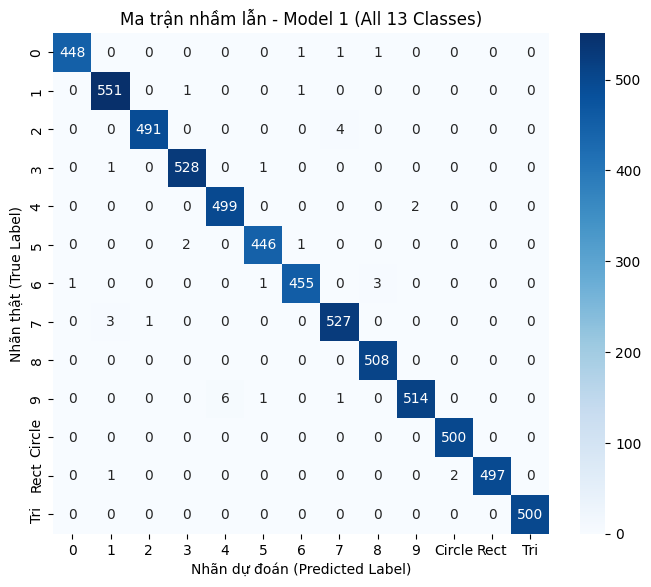

✅ Đã lưu model 13 lớp.


In [21]:
# Phần 7: Huấn luyện 3 Models
# Cell 7.1: Huấn luyện Model 1 (All - 13 Lớp)
# Khởi tạo model
model_all = ModernCNN(num_classes=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_all.parameters(), lr=0.001, weight_decay=1e-4)

# Huấn luyện (giảm epoch và augment_times để chạy nhanh hơn, bạn có thể tăng)
train_model(
    model_all,
    train_loader_all,
    val_loader_all,
    criterion,
    optimizer,
    num_epochs=10,
    augment_times=2, # Data lớn, augment 2 lần là đủ
    model_name="Model 1 (All 13 Classes)"
)

# Đánh giá
class_names_all = [str(i) for i in range(10)] + ["Circle", "Rect", "Tri"]
evaluate_model_and_report(model_all, test_loader_all, class_names_all, "Model 1 (All 13 Classes)")

# Lưu model
torch.save(model_all.state_dict(), os.path.join(DRIVE_PATH, "model_all_13.pth"))
print("✅ Đã lưu model 13 lớp.")

--- Bắt đầu Huấn luyện Model 2 (Digits Only) ---

🚀 Epoch 1/10


✅ Epoch [1/10] | Avg Loss: 0.1770
📊 Validation Accuracy: 99.20%
------------------------------------------------------------

🚀 Epoch 2/10


✅ Epoch [2/10] | Avg Loss: 0.0576
📊 Validation Accuracy: 99.54%
------------------------------------------------------------

🚀 Epoch 3/10


✅ Epoch [3/10] | Avg Loss: 0.0480
📊 Validation Accuracy: 99.48%
------------------------------------------------------------

🚀 Epoch 4/10


✅ Epoch [4/10] | Avg Loss: 0.0444
📊 Validation Accuracy: 99.50%
------------------------------------------------------------

🚀 Epoch 5/10


✅ Epoch [5/10] | Avg Loss: 0.0423
📊 Validation Accuracy: 99.46%
------------------------------------------------------------

🚀 Epoch 6/10


✅ Epoch [6/10] | Avg Loss: 0.0395
📊 Validation Accuracy: 99.34%
------------------------------------------------------------

🚀 Epoch 7/10


✅ Epoch [7/10] | Avg Loss: 0.0381
📊 Validation Accuracy: 99.66%
------------------------------------------------------------

🚀 Epoch 8/10


✅ Epoch [8/10] | Avg Loss: 0.0378
📊 Validation Accuracy: 99.52%
------------------------------------------------------------

🚀 Epoch 9/10


✅ Epoch [9/10] | Avg Loss: 0.0358
📊 Validation Accuracy: 99.50%
------------------------------------------------------------

🚀 Epoch 10/10


✅ Epoch [10/10] | Avg Loss: 0.0356
📊 Validation Accuracy: 99.56%
------------------------------------------------------------
--- Hoàn thành Huấn luyện Model 2 (Digits Only) ---

--- Đang Đánh giá Model 2 (Digits Only) trên tập Test ---


Đang đánh giá Model 2 (Digits Only): 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]



BÁO CÁO KẾT QUẢ CHO: Model 2 (Digits Only)
              precision    recall  f1-score   support

           0      0.996     0.998     0.997       451
           1      0.993     0.998     0.995       553
           2      0.994     0.996     0.995       495
           3      0.992     0.998     0.995       530
           4      0.988     0.994     0.991       501
           5      0.998     0.989     0.993       449
           6      0.993     0.991     0.992       460
           7      0.992     0.992     0.992       531
           8      0.998     0.996     0.997       508
           9      0.996     0.987     0.991       522

    accuracy                          0.994      5000
   macro avg      0.994     0.994     0.994      5000
weighted avg      0.994     0.994     0.994      5000



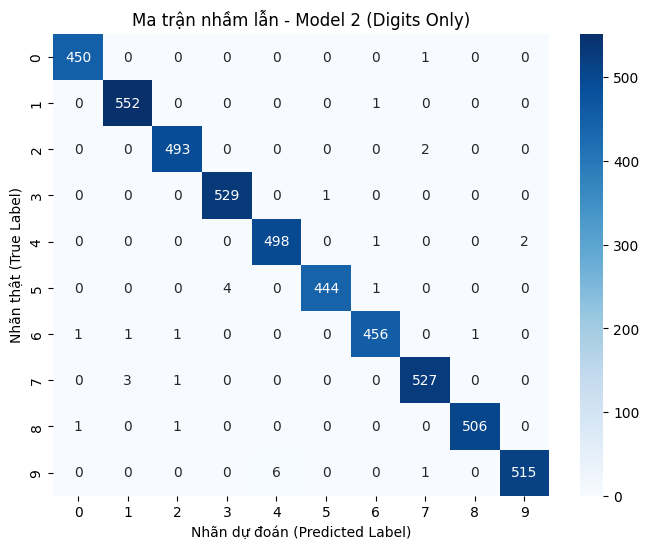

✅ Đã lưu model 10 lớp.


In [22]:
# Cell 7.2: Huấn luyện Model 2 (Digits - 10 Lớp)
# Khởi tạo model
model_digits = ModernCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_digits.parameters(), lr=0.001, weight_decay=1e-4)

# Huấn luyện
train_model(
    model_digits,
    train_loader_digits,
    val_loader_digits,
    criterion,
    optimizer,
    num_epochs=10,
    augment_times=2,
    model_name="Model 2 (Digits Only)"
)

# Đánh giá
class_names_digits = [str(i) for i in range(10)]
evaluate_model_and_report(model_digits, test_loader_digits, class_names_digits, "Model 2 (Digits Only)")

# Lưu model
torch.save(model_digits.state_dict(), os.path.join(DRIVE_PATH, "model_digits_10.pth"))
print("✅ Đã lưu model 10 lớp.")

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--- Bắt đầu Huấn luyện Model 3 (Shapes Only) ---

🚀 Epoch 1/10


✅ Epoch [1/10] | Avg Loss: 0.0274
📊 Validation Accuracy: 99.47%
------------------------------------------------------------

🚀 Epoch 2/10


✅ Epoch [2/10] | Avg Loss: 0.0025
📊 Validation Accuracy: 99.93%
------------------------------------------------------------

🚀 Epoch 3/10


✅ Epoch [3/10] | Avg Loss: 0.0025
📊 Validation Accuracy: 99.80%
------------------------------------------------------------

🚀 Epoch 4/10


✅ Epoch [4/10] | Avg Loss: 0.0031
📊 Validation Accuracy: 100.00%
------------------------------------------------------------

🚀 Epoch 5/10


✅ Epoch [5/10] | Avg Loss: 0.0019
📊 Validation Accuracy: 99.93%
------------------------------------------------------------

🚀 Epoch 6/10


✅ Epoch [6/10] | Avg Loss: 0.0032
📊 Validation Accuracy: 100.00%
------------------------------------------------------------

🚀 Epoch 7/10


✅ Epoch [7/10] | Avg Loss: 0.0020
📊 Validation Accuracy: 100.00%
------------------------------------------------------------

🚀 Epoch 8/10


✅ Epoch [8/10] | Avg Loss: 0.0016
📊 Validation Accuracy: 100.00%
------------------------------------------------------------

🚀 Epoch 9/10


✅ Epoch [9/10] | Avg Loss: 0.0022
📊 Validation Accuracy: 100.00%
------------------------------------------------------------

🚀 Epoch 10/10


✅ Epoch [10/10] | Avg Loss: 0.0020
📊 Validation Accuracy: 98.13%
------------------------------------------------------------
--- Hoàn thành Huấn luyện Model 3 (Shapes Only) ---

--- Đang Đánh giá Model 3 (Shapes Only) trên tập Test ---


Đang đánh giá Model 3 (Shapes Only): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


BÁO CÁO KẾT QUẢ CHO: Model 3 (Shapes Only)
               precision    recall  f1-score   support

   Circle (0)      1.000     1.000     1.000       500
Rectangle (1)      1.000     0.962     0.981       500
 Triangle (2)      0.963     1.000     0.981       500

     accuracy                          0.987      1500
    macro avg      0.988     0.987     0.987      1500
 weighted avg      0.988     0.987     0.987      1500



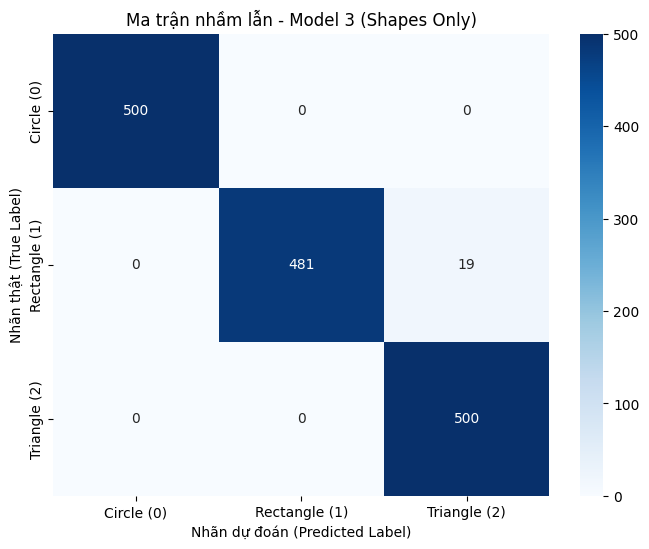

✅ Đã lưu model 3 lớp.


In [24]:
# Cell 7.3: Huấn luyện Model 3 (Shapes - 3 Lớp)
# Khởi tạo model
model_shapes = ModernCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_shapes.parameters(), lr=0.001, weight_decay=1e-4)

# Huấn luyện (Data ít hơn, augment 4 lần)
train_model(
    model_shapes,
    train_loader_shapes,
    val_loader_shapes,
    criterion,
    optimizer,
    num_epochs=10,
    augment_times=4,
    model_name="Model 3 (Shapes Only)"
)

# Đánh giá
class_names_shapes = ["Circle (0)", "Rectangle (1)", "Triangle (2)"]
evaluate_model_and_report(model_shapes, test_loader_shapes, class_names_shapes, "Model 3 (Shapes Only)")

# Lưu model
torch.save(model_shapes.state_dict(), os.path.join(DRIVE_PATH, "model_shapes_3.pth"))
print("✅ Đã lưu model 3 lớp.")

In [43]:
def preprocess_real_image_with_steps(image_path, target_size=28, box_size=20):
    """
    Hàm tiền xử lý (NÂNG CẤP): Tự động phát hiện loại ảnh
    (nền sáng hay nền tối) để xử lý cho đúng.
    """
    steps_images = {}

    img = cv2.imread(image_path)
    if img is None:
        print(f"Lỗi: Không thể đọc ảnh {image_path}")
        return None, None
    steps_images['1_Original'] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    steps_images['2_Grayscale'] = gray

    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    steps_images['3_Blurred'] = blurred

    # --- PHẦN NÂNG CẤP ---
    # Kiểm tra độ sáng trung bình của ảnh
    # Nếu > 128, giả định là nền sáng (ảnh chụp giấy trắng)
    if np.mean(gray) > 128:
        print("Phát hiện ảnh NỀN SÁNG (ảnh chụp thực tế). Áp dụng Adaptive Threshold.")
        thresh = cv2.adaptiveThreshold(blurred, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, # Nghịch đảo (mực đen -> trắng)
                                       11, 2)
    # Ngược lại, giả định là nền tối (ảnh dạng MNIST)
    else:
        print("Phát hiện ảnh NỀN TỐI (dạng MNIST). Áp dụng Threshold nhị phân.")
        # Chỉ cần threshold nhị phân đơn giản
        _, thresh = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

    steps_images['4_Threshold (Đã xử lý)'] = thresh
    # --- KẾT THÚC NÂNG CẤP ---

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Không tìm thấy đường viền.")
        return None, None

    main_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(main_contour)

    img_with_box = steps_images['1_Original'].copy()
    cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)
    steps_images['5_Found_Contour'] = img_with_box

    # Cắt ảnh (từ ảnh đã phân ngưỡng)
    digit_crop = thresh[y:y+h, x:x+w]
    steps_images['6_Cropped'] = digit_crop

    # Resize về 20x20 (giữ tỉ lệ)
    width, height = digit_crop.shape[1], digit_crop.shape[0]
    if width > height:
        new_w = box_size; new_h = int(height * (new_w / width))
    else:
        new_h = box_size; new_w = int(width * (new_h / height))

    resized = cv2.resize(digit_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
    steps_images['7_Resized_20x20'] = resized

    # Tạo canvas 28x28 và dán vào giữa
    canvas = np.zeros((target_size, target_size), dtype=np.uint8)
    start_x = (target_size - new_w) // 2
    start_y = (target_size - new_h) // 2
    canvas[start_y:start_y + new_h, start_x:start_x + new_w] = resized
    steps_images['8_Final_28x28'] = canvas

    final_pil_image = Image.fromarray(canvas)

    return final_pil_image, steps_images

In [44]:
# Cell 8.2: Hàm plot_steps
def plot_steps(steps_images):
    """Hiển thị 8 bước tiền xử lý trên lưới 2x4."""
    if steps_images is None:
        return

    print("--- Hiển thị các bước tiền xử lý ---")
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, (title, img) in enumerate(steps_images.items()):
        # Kiểm tra ảnh RGB (ảnh gốc) hay ảnh xám
        cmap = 'gray' if img.ndim == 2 else None
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [45]:
# Cell 8.3: Hàm predict_real_image (Hàm tổng hợp)
def predict_real_image(image_path, model, class_names_map):
    """
    Hàm tổng hợp: Tiền xử lý, Hiển thị bước, và Dự đoán
    """
    print(f"\n" + "="*60)
    print(f"--- ĐANG DỰ ĐOÁN ẢNH: {image_path} ---")
    print(f"--- MODEL: {list(class_names_map.values())[:3]}... ---")
    print("="*60)

    # 1. Tiền xử lý VÀ lấy các bước (Cell 8.1)
    processed_pil_img, steps = preprocess_real_image_with_steps(image_path)

    # 2. Hiển thị các bước (Cell 8.2)
    plot_steps(steps)

    if processed_pil_img is None:
        print("Không thể xử lý ảnh.")
        return

    # 3. Chuẩn bị ảnh cho model (dùng test_transform)
    transform = test_transform # Đã định nghĩa ở Cell 4.1
    img_tensor = transform(processed_pil_img).unsqueeze(0).to(device)

    # 4. Dự đoán
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    pred_label = predicted_idx.item()
    pred_class = class_names_map.get(pred_label, f"Lỗi Nhãn {pred_label}")
    conf = confidence.item() * 100

    # 5. Hiển thị kết quả cuối cùng
    print(f"\n==> KẾT QUẢ DỰ ĐOÁN: {pred_class} (Độ tự tin: {conf:.2f}%)")
    plt.figure(figsize=(4, 4))
    plt.imshow(processed_pil_img, cmap="gray")
    plt.title(f"Dự đoán: {pred_class}\nConfidence: {conf:.2f}%")
    plt.axis('off')
    plt.show()

Đang tải lại các model đã huấn luyện...
Tải model thành công.

--- ĐANG DỰ ĐOÁN ẢNH: /content/drive/MyDrive/XLA/test/circle_2.png ---
--- MODEL: ['0', '1', '2']... ---
Phát hiện ảnh NỀN TỐI (dạng MNIST). Áp dụng Threshold nhị phân.
--- Hiển thị các bước tiền xử lý ---


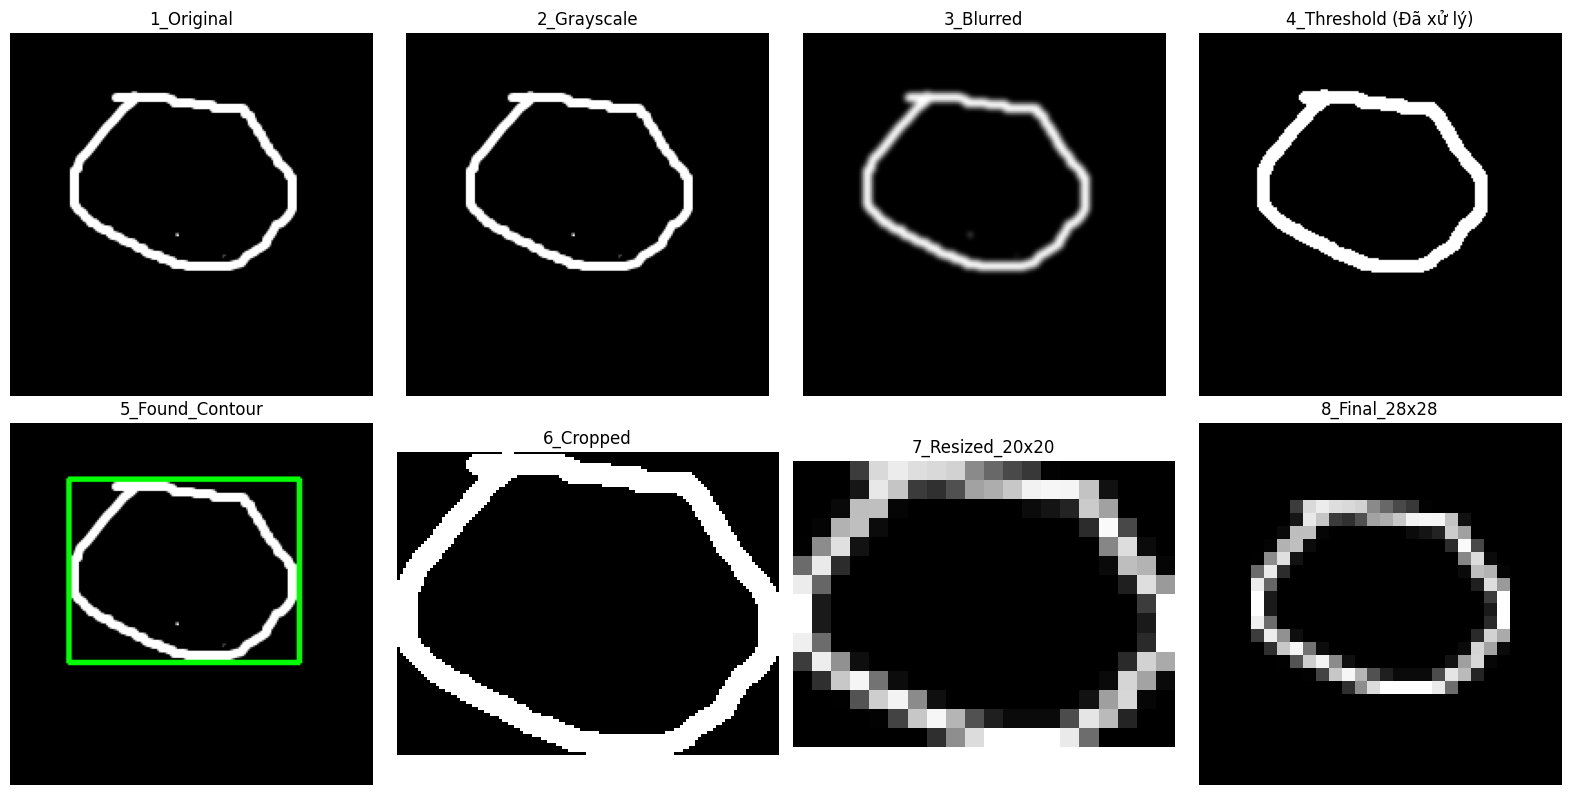


==> KẾT QUẢ DỰ ĐOÁN: 0 (Độ tự tin: 99.96%)


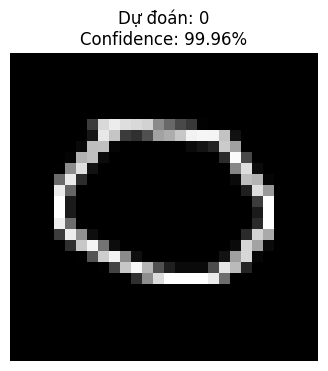

In [54]:
# Cell 8.4: Chạy Thử nghiệm Dự đoán
# --- 1. Tải lại 3 model đã huấn luyện ---
# (Đảm bảo các cell 7.1, 7.2, 7.3 đã chạy thành công)
print("Đang tải lại các model đã huấn luyện...")
try:
    model_all = ModernCNN(num_classes=13).to(device)
    model_all.load_state_dict(torch.load(os.path.join(DRIVE_PATH, "model_all_13.pth"), map_location=device))

    model_digits = ModernCNN(num_classes=10).to(device)
    model_digits.load_state_dict(torch.load(os.path.join(DRIVE_PATH, "model_digits_10.pth"), map_location=device))

    model_shapes = ModernCNN(num_classes=3).to(device)
    model_shapes.load_state_dict(torch.load(os.path.join(DRIVE_PATH, "model_shapes_3.pth"), map_location=device))
    print("Tải model thành công.")
except Exception as e:
    print(f"Lỗi khi tải model. Bạn đã huấn luyện và lưu model chưa? Lỗi: {e}")

# --- 2. Định nghĩa các map nhãn ---
map_all = {**{i: str(i) for i in range(10)}, 10: "Hình tròn", 11: "Hình chữ nhật", 12: "Hình tam giác"}
map_digits = {i: str(i) for i in range(10)}
map_shapes = {0: "Hình tròn", 1: "Hình chữ nhật", 2: "Hình tam giác"}

# --- 3. Tạo ảnh test giả (nền trắng, chữ đen) ---
test_img_5 = np.zeros((200, 200), dtype=np.uint8); test_img_5.fill(255)
cv2.putText(test_img_5, '5', (40, 150), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 12, cv2.LINE_AA)
cv2.imwrite('my_test_digit_5.png', test_img_5)

test_shape_tri = np.zeros((200, 200), dtype=np.uint8); test_shape_tri.fill(255)
pts = np.array([[100, 20], [40, 180], [160, 180]], np.int32).reshape((-1, 1, 2))
cv2.polylines(test_shape_tri, [pts], isClosed=True, color=(0,0,0), thickness=5)
cv2.imwrite('my_test_shape_triangle.png', test_shape_tri)

# --- 4. Chạy dự đoán ---
# (Bạn có thể thay 'my_test_digit_5.png' bằng file ảnh của bạn)
image_path_digit = '/content/drive/MyDrive/XLA/test/circle_2.png'
image_path_shape = '/content/drive/MyDrive/XLA/test/1_0.png'

# Test ảnh chữ số
predict_real_image(image_path_digit, model_all, map_all)
# predict_real_image(image_path_digit, model_digits, map_digits)

# Test ảnh hình học
# predict_real_image(image_path_shape, model_all, map_all)
# predict_real_image(image_path_shape, model_shapes, map_shapes)